In [1]:
!pip install holidays_ru

In [29]:
import holidays_ru
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE

from catboost import CatBoostRegressor, Pool
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
import prophet

import optuna

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/views.csv
/kaggle/input/train.csv
/kaggle/input/tvrs_reach.csv
/kaggle/input/test.csv


## Train data reading and features renaming

In [171]:
train = pd.read_csv('/kaggle/input/train.csv', delimiter=';')
train = train.set_axis(['Target', 'Date', 
                        'Break_id', 'Break_start', 'Break_end', 'Break_content', 'Break_distribution',
                        'Programme_name', 'Programme_start', 'Programme_end', 'Programme_category', 
                        'Programme_genre'], axis=1)
train = train.convert_dtypes()
train.head()

,Target,Date,Break_id,Break_start,Break_end,Break_content,Break_distribution,Programme_name,Programme_start,Programme_end,Programme_category,Programme_genre
0,"0,614692654",02.01.2023,4870830561,8:17:33,8:21:40,Commercial,Network,"Telekanal ""Dobroe utro""",8:00:13,10:00:14,Morning airplay,Entertainment programs
1,"0,869565217",02.01.2023,4870830614,8:34:45,8:38:52,Commercial,Network,"Telekanal ""Dobroe utro""",8:00:13,10:00:14,Morning airplay,Entertainment programs
2,"0,989505247",02.01.2023,4870830629,8:52:19,8:56:23,Commercial,Network,"Telekanal ""Dobroe utro""",8:00:13,10:00:14,Morning airplay,Entertainment programs
3,"0,884557721",02.01.2023,4870830684,8:56:31,8:57:28,Announcement,Network,"Telekanal ""Dobroe utro""",8:00:13,10:00:14,Morning airplay,Entertainment programs
4,"0,83958021",02.01.2023,4870830685,9:12:04,9:16:13,Commercial,Network,"Telekanal ""Dobroe utro""",8:00:13,10:00:14,Morning airplay,Entertainment programs


In [172]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30682 entries, 0 to 30681
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Target              30682 non-null  string
 1   Date                30682 non-null  string
 2   Break_id            30682 non-null  Int64 
 3   Break_start         30682 non-null  string
 4   Break_end           30682 non-null  string
 5   Break_content       30682 non-null  string
 6   Break_distribution  30682 non-null  string
 7   Programme_name      30682 non-null  string
 8   Programme_start     30682 non-null  string
 9   Programme_end       30682 non-null  string
 10  Programme_category  30682 non-null  string
 11  Programme_genre     30682 non-null  string
dtypes: Int64(1), string(11)
memory usage: 2.8 MB


## Preprocessing and feature engineering

In [173]:
def time_preproc(df, is_test=False):
    if not is_test:
        train['Target'] = train['Target'].apply(lambda x: float(x.replace(',', '.')))

    df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')

    df['Break_start_hour'] = df['Break_start'].apply(lambda x: int(x.split(':')[0]))
    df['Break_start_min'] = df['Break_start'].apply(lambda x: int(x.split(':')[1]))
    df['Break_start_sec'] = df['Break_start'].apply(lambda x: int(x.split(':')[2]))
    df['Break_start_abs'] = 60 * df['Break_start_hour'] + df['Break_start_min']

    df['Break_end_hour'] = df['Break_end'].apply(lambda x: int(x.split(':')[0]))
    df['Break_end_min'] = df['Break_end'].apply(lambda x: int(x.split(':')[1]))
    df['Break_end_sec'] = df['Break_end'].apply(lambda x: int(x.split(':')[2]))
    df['Break_end_abs'] = 60 * df['Break_end_hour'] + df['Break_end_min']

    df['Programme_start_hour'] = df['Programme_start'].apply(lambda x: int(x.split(':')[0]))
    df['Programme_start_min'] = df['Programme_start'].apply(lambda x: int(x.split(':')[1]))
    df['Programme_start_sec'] = df['Programme_start'].apply(lambda x: int(x.split(':')[2]))
    df['Programme_start_abs'] = 60 * df['Programme_start_hour'] + df['Programme_start_min']

    df['Programme_end_hour'] = df['Programme_end'].apply(lambda x: int(x.split(':')[0]))
    df['Programme_end_min'] = df['Programme_end'].apply(lambda x: int(x.split(':')[1]))
    df['Programme_end_sec'] = df['Programme_end'].apply(lambda x: int(x.split(':')[2]))
    df['Programme_end_abs'] = 60 * df['Programme_end_hour'] + df['Programme_end_min']

    df = df.drop(columns=['Break_start', 'Break_end', 'Programme_start', 'Programme_end'])
    return df

In [174]:
train = time_preproc(train)

### Basic features

In [175]:
def gen_base_features(df, is_test=False):
    df['Weekday'] = df['Date'].apply(lambda x: x.weekday())
    df['Weekend'] = df['Weekday'] > 4
    df['Holiday'] = df['Date'].apply(lambda x: holidays_ru.check_holiday(x, False))
    df['Pre_holiday'] = df['Date'].apply(lambda x: (not holidays_ru.check_holiday(x, False)) and holidays_ru.check_holiday(x + datetime.timedelta(days=1), False))
    
    df['Break_duration'] = (3600 * df['Break_end_hour'] + 60 * df['Break_end_min'] + df['Break_end_sec']) - \
                          (3600 * df['Break_start_hour'] + 60 * df['Break_start_min'] + df['Break_start_sec'])
                          
    df['Programme_duration'] = (3600 * df['Programme_end_hour'] + 60 * df['Programme_end_min'] + df['Programme_end_sec']) - \
                                  (3600 * df['Programme_start_hour'] + 60 * df['Programme_start_min'] + df['Programme_start_sec'])
    df['From_progamme_start'] = (3600 * df['Break_end_hour'] + 60 * df['Break_end_min'] + df['Break_end_sec']) - \
                                (3600 * df['Programme_start_hour'] + 60 * df['Programme_start_min'] + df['Programme_start_sec'])
    df['Until_progamme_end'] = (3600 * df['Programme_end_hour'] + 60 * df['Programme_end_min'] + df['Programme_end_sec']) - \
                               (3600 * df['Break_start_hour'] + 60 * df['Break_start_min'] + df['Break_start_sec'])
                               
    df['Break_of_programme_fraction'] = df['From_progamme_start'] / df['Programme_duration']
    
    return df

In [176]:
train = gen_base_features(train)
train.shape

(30682, 33)

### TV viewing feature

In [177]:
views = pd.read_csv('/kaggle/input/views.csv', delimiter=';')
views = views.replace(np.nan, '0,0')
views['2021'] = views['2021'].apply(lambda x: float(x.replace(',', '.')))
views['2022'] = views['2022'].apply(lambda x: float(x.replace(',', '.')))
views['2023'] = views['2023'].apply(lambda x: float(x.replace(',', '.')))

#Prophet
y = np.hstack([views['2021'].values, views['2022'].values, views['2023'].iloc[:-2].values])
ds = [datetime.date(2021, i, 1) for i in range(1, 13)] + \
     [datetime.date(2022, i, 1) for i in range(1, 13)] + \
     [datetime.date(2023, i, 1) for i in range(1, 11)]
views_prop = pd.DataFrame({'ds': ds,
                           'y': y})
model_prophet = prophet.Prophet(growth='linear', yearly_seasonality=1)
model_prophet.fit(views_prop)
future = model_prophet.make_future_dataframe(periods=1, freq='m')
forecast = model_prophet.predict(future)
views_2023 = views['2023'].iloc[:10].tolist() + [forecast['yhat'].iloc[-1]] 
views_by_month_Prop = {month: views_2023[month-1] for month in range(1,12)}

21:07:43 - cmdstanpy - INFO - Chain [1] start processing
21:07:44 - cmdstanpy - INFO - Chain [1] done processing


### Aggregate statistics by Programme_genre

In [178]:
genre_stats = train.groupby('Programme_genre')['Target'].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()
genre_stats.rename(columns={
    'mean': 'genre_mean_rating', 
    'std': 'genre_std_rating', 
    'min': 'genre_min_rating', 
    'max': 'genre_max_rating', 
    'median': 'genre_median_rating', 
}, inplace=True)
genre_stats

,Programme_genre,genre_mean_rating,genre_std_rating,genre_min_rating,genre_max_rating,genre_median_rating
0,Educational program,0.507373,0.225188,0.089955,2.788606,0.479760
1,Entertainment programs,1.093739,0.699036,0.000000,4.587706,1.094453
2,Musical programs,0.240270,0.091633,0.044978,0.509745,0.239880
3,News,2.189251,0.782455,0.599700,5.052474,2.098951
4,Social-political programs,0.935144,0.377642,0.089955,3.793103,0.869565


### Aggregate statistics by Programme_category

In [179]:
category_stats = train.groupby('Programme_category')['Target'].agg(['mean', 'std', 'min', 'max', 'median']).reset_index()
category_stats.rename(columns={
    'mean': 'category_mean_rating', 
    'std': 'category_std_rating', 
    'min': 'category_min_rating', 
    'max': 'category_max_rating', 
    'median': 'category_median_rating', 

}, inplace=True)
category_stats

,Programme_category,category_mean_rating,category_std_rating,category_min_rating,category_max_rating,category_median_rating
0,Comic program,0.985206,0.319753,0.299850,2.293853,0.944528
1,Daily news,2.189251,0.782455,0.599700,5.052474,2.098951
2,Entertainment talk show,0.812077,0.733601,0.000000,2.863568,0.659670
3,Folk music and dances,0.240270,0.091633,0.044978,0.509745,0.239880
4,Geography and countries,0.825791,0.347822,0.224888,2.788606,0.794603
5,Law and justice,1.854707,0.603826,0.569715,3.793103,1.799100
6,"Mixed concert, show, circus performance",1.481145,0.446519,0.569715,3.013493,1.454273
7,Morning airplay,1.112456,0.418890,0.059970,2.278861,1.139430
8,"Program for women, Cookery show",1.045750,0.301341,0.359820,1.829085,1.049475
9,Program on fashion and design,0.782656,0.261707,0.344828,1.754123,0.734633


### Per program features

In [180]:
# Number of ad blocks per program
ad_blocks_per_program = train.groupby('Programme_name')['Break_id'].nunique().reset_index(name='total_ad_blocks_per_program')
# Average duration of ad blocks per program (assuming 'Break_duration' is already calculated in minutes)
avg_ad_duration_per_program = train.groupby('Programme_name')['Break_duration'].mean().reset_index(name='avg_ad_block_duration')

### Average target rating by day of the week

In [181]:
avg_rating_by_day_of_week = train.groupby('Weekday')['Target'].mean().reset_index(name='avg_rating_by_day_of_week')
avg_rating_by_day_of_week

,Weekday,avg_rating_by_day_of_week
0,0,0.988667
1,1,0.995820
2,2,1.007417
3,3,0.976581
4,4,1.253812
5,5,0.760885
6,6,0.787756


### Timeslot rating

In [182]:
rating_timeslot = train.groupby('Break_start_hour')['Target'].mean().reset_index(name='avg_rating_by_timeslot')
peak_time = rating_timeslot.loc[rating_timeslot['avg_rating_by_timeslot'].idxmax()]
peak_time

Break_start_hour          21.000000
avg_rating_by_timeslot     2.647665
Name: 16, dtype: float64

### Some extra features

In [183]:
extra_feats = pd.read_csv('/kaggle/input/tvrs_reach.csv', delimiter=';')
extra_feats = extra_feats[['Reach_4+', 'Reach_18+', 'TVR_4+', 'TVR_All_18+', 
                          'Total_Channels_TVR_4+', 'Total_Channels_TVR_All_18+']]
for col in extra_feats.columns:
    extra_feats[col] = extra_feats[col].apply(lambda x: float(str(x).replace(',', '.')))
extra_feats.convert_dtypes()
extra_feats

,Reach_4+,Reach_18+,TVR_4+,TVR_All_18+,Total_Channels_TVR_4+,Total_Channels_TVR_All_18+
0,34359.0,32570.0,1.17,1.36,16.38,18.40
1,32747.0,31114.0,1.19,1.40,15.92,17.90
2,32064.0,30535.0,1.17,1.37,15.29,17.17
3,29841.0,28422.0,1.05,1.23,14.16,15.94
4,30601.0,29057.0,1.09,1.28,13.51,15.20
5,29443.0,28050.0,1.00,1.18,13.08,14.72
6,27987.0,26764.0,0.99,1.17,12.76,14.35
7,27421.0,26211.0,0.98,1.16,12.80,14.33
8,27332.0,26043.0,0.96,1.13,13.20,14.88
9,28822.0,27428.0,1.02,1.20,14.06,15.86


### Merge all features

In [184]:
def gen_more_features(df):
#     for col in extra_feats.columns:
#         df[col] = df['Date'].apply(lambda x: extra_feats.loc[x.month-1, col])
    df['Avg_views'] = df['Date'].apply(lambda x: views_by_month_Prop[x.month])
    df = df.merge(genre_stats, on='Programme_genre', how='left')
    df = df.merge(category_stats, on='Programme_category', how='left')
    df = df.merge(ad_blocks_per_program, on='Programme_name', how='left')
    df = df.merge(avg_ad_duration_per_program, on='Programme_name', how='left')
    df = df.merge(avg_rating_by_day_of_week, on='Weekday', how='left')
    df = df.merge(rating_timeslot, on='Break_start_hour', how='left')
    return df

In [185]:
train = gen_more_features(train)

In [186]:
features_to_drop = ['Break_start_sec', 'Break_end_sec', 
                    'Programme_start_sec', 'Programme_end_sec',
                    'Avg_views']   
# ['Pre_holiday', 'Break_start_sec', 'Break_end_sec', 'Holiday', 
# 'Break_end_min', 'Break_of_programme_fraction', 
# 'Programme_category', 'Break_start_min', 'Programme_genre', 'Break_content']

def drop_features(df):
    return df.drop(columns=features_to_drop)

In [187]:
train = drop_features(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30682 entries, 0 to 30681
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Target                       30682 non-null  float64       
 1   Date                         30682 non-null  datetime64[ns]
 2   Break_id                     30682 non-null  Int64         
 3   Break_content                30682 non-null  string        
 4   Break_distribution           30682 non-null  string        
 5   Programme_name               30682 non-null  string        
 6   Programme_category           30682 non-null  string        
 7   Programme_genre              30682 non-null  string        
 8   Break_start_hour             30682 non-null  int64         
 9   Break_start_min              30682 non-null  int64         
 10  Break_start_abs              30682 non-null  int64         
 11  Break_end_hour               30682 non-nu

In [188]:
cat_features = list(set(['Break_content', 'Break_distribution', 'Programme_name', 'Programme_category', 
                         'Programme_genre', 'Weekday', 'Weekend', 'Holiday', 'Pre_holiday']) \
                    - set(features_to_drop))

In [189]:
# drop Local break dictribution
train = train.drop(index=train[train['Break_distribution'] == 'Local'].index)
# drop zero Targets
train = train.drop(index=train[train['Target'] == 0].index)
train.shape

(30571, 43)

In [190]:
y = train['Target']
X = train.drop(['Target', 'Date', 'Break_id'], axis=1)
X.shape, y.shape

((30571, 40), (30571,))

In [192]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
train_idx = train[train['Date'].apply(lambda x: x.month == 10)].index
valid_idx = train[train['Date'].apply(lambda x: x.month < 10)].index
X_train = X.drop(index=train_idx)
y_train = y.drop(index=train_idx)
X_valid = X.drop(index=valid_idx)
y_valid = y.drop(index=valid_idx)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape 

((27332, 40), (27332,), (3239, 40), (3239,))

## CatBoost

In [ ]:
models = []

In [271]:
scale_target = 1  # 0.6482
train_pool = Pool(X_train, label=y_train * scale_target, cat_features=cat_features)
valid_pool = Pool(X_valid, label=y_valid * scale_target, cat_features=cat_features)

ctb_params = dict(iterations=7000,
                   learning_rate=0.007,  #0.0837, #0.02778,
                   depth=7,  #8,  #9
                   l2_leaf_reg=3,
                   bootstrap_type='Bernoulli',
                   subsample=0.6,  #0.9763,  #0.997,
                   colsample_bylevel=0.66,#0.66  # #0.795,
                   loss_function='MAPE',
                   eval_metric='MAPE',
                   metric_period=100,
                   random_strength=0.69, #1  # more bagging to reduce overfitting
#                    task_type='GPU',
#                    devices='0:1',
#                    use_best_model=False,
                   random_state=42,
                   allow_writing_files=False,
                  )
model = CatBoostRegressor(**ctb_params)  # loss_function=MapeObjective(), 
model.fit(train_pool, 
          eval_set=valid_pool,
          early_stopping_rounds=100,
         )

0:	learn: 0.3331300	test: 0.3778650	best: 0.3778650 (0)	total: 27.5ms	remaining: 3m 12s
100:	learn: 0.2188884	test: 0.2449452	best: 0.2449452 (100)	total: 2.57s	remaining: 2m 55s
200:	learn: 0.1769089	test: 0.1862789	best: 0.1862789 (200)	total: 5.02s	remaining: 2m 49s
300:	learn: 0.1614349	test: 0.1600923	best: 0.1600923 (300)	total: 7.47s	remaining: 2m 46s
400:	learn: 0.1541860	test: 0.1465943	best: 0.1465943 (400)	total: 10.3s	remaining: 2m 50s
500:	learn: 0.1500780	test: 0.1393916	best: 0.1393916 (500)	total: 12.9s	remaining: 2m 46s
600:	learn: 0.1474893	test: 0.1348526	best: 0.1348526 (600)	total: 15.4s	remaining: 2m 43s
700:	learn: 0.1454787	test: 0.1315811	best: 0.1315811 (700)	total: 17.8s	remaining: 2m 39s
800:	learn: 0.1436398	test: 0.1291420	best: 0.1291420 (800)	total: 20.2s	remaining: 2m 36s
900:	learn: 0.1422223	test: 0.1273951	best: 0.1273951 (900)	total: 22.6s	remaining: 2m 33s
1000:	learn: 0.1410761	test: 0.1261320	best: 0.1261320 (1000)	total: 25.1s	remaining: 2m 30s


In [272]:
MAPE(y_valid * scale_target, model.predict(X_valid))

0.24021606088727576

#### Postprocessing

In [273]:
preds = model.predict(X_valid)
preds = [max(0.01499, pred) for pred in preds]
MAPE(y_valid * scale_target, preds)

0.2401257506788972

In [274]:
models.append(model)

## 3-fold blending

In [248]:
folds_idx = []
folds_idx.append(train[train['Date'].apply(lambda x: x.month <= 2)].index)
folds_idx.append(train[train['Date'].apply(lambda x: x.month > 2 and x.month <= 4)].index)
folds_idx.append(train[train['Date'].apply(lambda x: x.month > 4 and x.month <= 6)].index)
folds_idx.append(train[train['Date'].apply(lambda x: x.month > 6 and x.month <= 8)].index)
folds_idx.append(train[train['Date'].apply(lambda x: x.month > 8 and x.month <= 9)].index)
# folds_idx.append(train[train['Date'].apply(lambda x: x.month > 5 and x.month <= 9)].index)
models = []
scores = []
for fold in range(3):
    print(f'{fold=}')
    valid_idx = np.array(folds_idx[fold])
    train_idx = np.hstack(folds_idx[:fold] + folds_idx[fold+1:])
    X_fold_train = X_train.drop(index=train_idx)
    y_fold_train = y_train.drop(index=train_idx)
    X_fold_valid = X_train.drop(index=valid_idx)
    y_fold_valid = y_train.drop(index=valid_idx)
    train_pool = Pool(X_fold_train, label=y_fold_train, cat_features=cat_features)
    valid_pool = Pool(X_fold_valid, label=y_fold_valid, cat_features=cat_features)

    ctb_params = dict(iterations=7000,
                       learning_rate=0.006,
                       depth=7,
                       l2_leaf_reg=3,
                       bootstrap_type='Bernoulli',
                       subsample=0.6,
                       colsample_bylevel=0.66,
                       loss_function='MAPE',
                       eval_metric='MAPE',
                       metric_period=100,
                       random_strength=0.69,
                       random_state=42*fold,
                       allow_writing_files=False,
                      )
    model = CatBoostRegressor(**ctb_params)
    model.fit(train_pool, 
              eval_set=valid_pool,
              early_stopping_rounds=100,
             )
    models.append(model)
    score = MAPE(y_fold_valid, model.predict(X_fold_valid))
    print(f"fold MAPE = {score}")
    scores.append(score)

fold=0


0:	learn: 0.3417504	test: 0.3402183	best: 0.3402183 (0)	total: 13.9ms	remaining: 1m 37s
100:	learn: 0.2339302	test: 0.2488199	best: 0.2488199 (100)	total: 1.31s	remaining: 1m 29s
200:	learn: 0.1839803	test: 0.2151536	best: 0.2151536 (200)	total: 2.62s	remaining: 1m 28s
300:	learn: 0.1608368	test: 0.2032334	best: 0.2032334 (300)	total: 3.9s	remaining: 1m 26s
400:	learn: 0.1487110	test: 0.1979147	best: 0.1979147 (400)	total: 5.18s	remaining: 1m 25s
500:	learn: 0.1410704	test: 0.1947015	best: 0.1947015 (500)	total: 6.45s	remaining: 1m 23s
600:	learn: 0.1361702	test: 0.1933977	best: 0.1933972 (599)	total: 7.71s	remaining: 1m 22s
700:	learn: 0.1324354	test: 0.1928749	best: 0.1928623 (691)	total: 8.96s	remaining: 1m 20s
800:	learn: 0.1297895	test: 0.1927891	best: 0.1926757 (745)	total: 10.4s	remaining: 1m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1926757179
bestIteration = 745

Shrink model to first 746 iterations.
fold MAPE = 0.3440505866964568
fold=1


0:	learn: 0.3438014	test: 0.3314398	best: 0.3314398 (0)	total: 12.5ms	remaining: 1m 27s
100:	learn: 0.2271282	test: 0.2376454	best: 0.2376454 (100)	total: 1.32s	remaining: 1m 30s
200:	learn: 0.1737021	test: 0.2014652	best: 0.2014652 (200)	total: 2.62s	remaining: 1m 28s
300:	learn: 0.1496593	test: 0.1873891	best: 0.1873891 (300)	total: 3.92s	remaining: 1m 27s
400:	learn: 0.1374520	test: 0.1814577	best: 0.1814577 (400)	total: 5.27s	remaining: 1m 26s
500:	learn: 0.1300384	test: 0.1782064	best: 0.1782064 (500)	total: 6.59s	remaining: 1m 25s
600:	learn: 0.1255525	test: 0.1761671	best: 0.1761671 (600)	total: 7.92s	remaining: 1m 24s
700:	learn: 0.1226205	test: 0.1751085	best: 0.1751085 (700)	total: 9.25s	remaining: 1m 23s
800:	learn: 0.1200413	test: 0.1743252	best: 0.1743252 (800)	total: 10.6s	remaining: 1m 21s
900:	learn: 0.1180239	test: 0.1738404	best: 0.1738404 (900)	total: 11.8s	remaining: 1m 20s
1000:	learn: 0.1164435	test: 0.1733980	best: 0.1733967 (999)	total: 13.1s	remaining: 1m 18s
1

0:	learn: 0.3346034	test: 0.3336710	best: 0.3336710 (0)	total: 14.8ms	remaining: 1m 43s
100:	learn: 0.2244817	test: 0.2375170	best: 0.2375170 (100)	total: 1.36s	remaining: 1m 32s
200:	learn: 0.1763157	test: 0.1961927	best: 0.1961927 (200)	total: 2.65s	remaining: 1m 29s
300:	learn: 0.1542865	test: 0.1787257	best: 0.1787257 (300)	total: 3.98s	remaining: 1m 28s
400:	learn: 0.1437936	test: 0.1708384	best: 0.1708384 (400)	total: 5.34s	remaining: 1m 27s
500:	learn: 0.1379990	test: 0.1664314	best: 0.1664314 (500)	total: 6.66s	remaining: 1m 26s
600:	learn: 0.1342213	test: 0.1638787	best: 0.1638787 (600)	total: 7.97s	remaining: 1m 24s
700:	learn: 0.1312203	test: 0.1619179	best: 0.1619179 (700)	total: 9.25s	remaining: 1m 23s
800:	learn: 0.1287790	test: 0.1606292	best: 0.1606292 (800)	total: 10.6s	remaining: 1m 21s
900:	learn: 0.1264814	test: 0.1597056	best: 0.1597056 (900)	total: 11.9s	remaining: 1m 20s
1000:	learn: 0.1246055	test: 0.1590827	best: 0.1590827 (1000)	total: 13.1s	remaining: 1m 18s


In [277]:
preds_list = []
for i, model in enumerate(models[3:5]):
    preds_list.append(model.predict(X_valid))
    score = MAPE(y_valid, preds_list[-1])
    print(f"{i+1}: valid MAPE = {score}")
preds = sum(preds_list)/len(preds_list)
score = MAPE(y_valid, preds)
print(f"blend valid MAPE = {score}")

1: valid MAPE = 0.23796136803476833
2: valid MAPE = 0.23733122362354517
blend valid MAPE = 0.23720186401907997


In [247]:
preds_list = []
for i, model in enumerate(models):
    preds_list.append(model.predict(X_valid))
    score = MAPE(y_valid, preds_list[-1])
    print(f"{i+1}: valid MAPE = {score}")
preds = sum(preds_list)/len(preds_list)
score = MAPE(y_valid, preds)
print(f"blend valid MAPE = {score}")

1: valid MAPE = 0.43379695715448013
2: valid MAPE = 0.43020814397122314
3: valid MAPE = 0.3796400818559201
4: valid MAPE = 0.2796525107085405
5: valid MAPE = 0.28524434278263733
blend valid MAPE = 0.3440448990708819


In [245]:
preds_list = []
for i, model in enumerate(models):
    preds_list.append(model.predict(X_valid))
    score = MAPE(y_valid, preds_list[-1])
    print(f"{i+1}: valid MAPE = {score}")
preds = sum(preds_list)/len(preds_list)
score = MAPE(y_valid, preds)
print(f"blend valid MAPE = {score}")

1: valid MAPE = 0.4068289731715084
2: valid MAPE = 0.29228849528276013
3: valid MAPE = 0.28239912095224334
blend valid MAPE = 0.3115404634301321


In [242]:
preds_list = []
for i, model in enumerate(models):
    preds_list.append(model.predict(X_valid))
    score = MAPE(y_valid, preds_list[-1])
    print(f"{i+1}: valid MAPE = {score}")
preds = sum(preds_list)/len(preds_list)
score = MAPE(y_valid, preds)
print(f"blend valid MAPE = {score}")

1: valid MAPE = 0.41255054387522444
2: valid MAPE = 0.26218856317136163
3: valid MAPE = 0.2602800445233952
blend valid MAPE = 0.28977635436682236


## Feature importance and elimination

Text(0.5, 1.0, 'CatBoost top features importance')

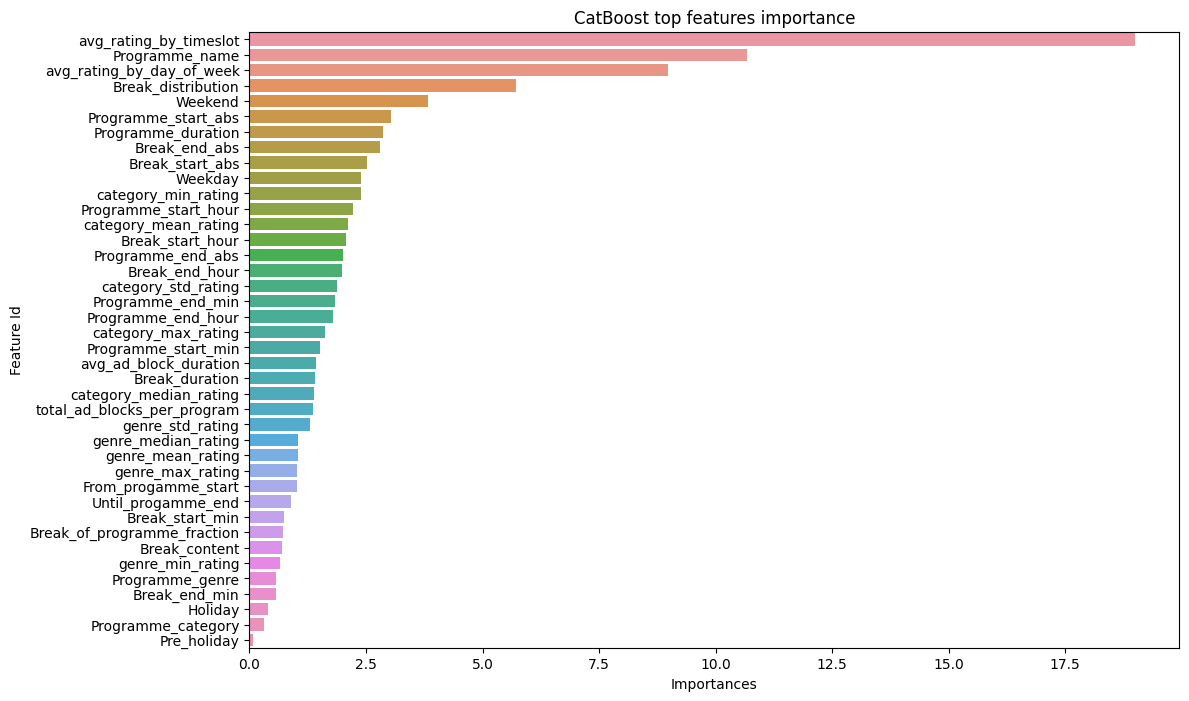

In [196]:
feature_importances = model.get_feature_importance(prettified=True)
plt.figure(figsize=(12, 8))
sns.barplot(x="Importances", y="Feature Id", data=feature_importances.loc[:, :])
plt.title('CatBoost top features importance')

## Feature elimination by SHAP

In [167]:
ctb_model = CatBoostRegressor(**ctb_params)
summary_shap = ctb_model.select_features(train_pool,
                                        eval_set=valid_pool,
                                        features_for_select=list(X_train.columns),
                                        num_features_to_select=25,
                                        steps=4,
                                        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
                                        shap_calc_type=EShapCalcType.Regular,
                                        train_final_model=True,
                                        plot=True,
                                        verbose=True,
                                        )
summary_shap['eliminated_features_names']

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 4
0:	learn: 0.3331131	test: 0.3777535	best: 0.3777535 (0)	total: 43.2ms	remaining: 2m 31s
100:	learn: 0.2184536	test: 0.2469748	best: 0.2469748 (100)	total: 2.94s	remaining: 1m 38s
200:	learn: 0.1736581	test: 0.1906655	best: 0.1906655 (200)	total: 5.58s	remaining: 1m 31s
300:	learn: 0.1557233	test: 0.1670107	best: 0.1670107 (300)	total: 8.15s	remaining: 1m 26s
400:	learn: 0.1463137	test: 0.1537412	best: 0.1537412 (400)	total: 10.7s	remaining: 1m 22s
500:	learn: 0.1406663	test: 0.1462627	best: 0.1462627 (500)	total: 13.5s	remaining: 1m 20s
600:	learn: 0.1370378	test: 0.1417906	best: 0.1417906 (600)	total: 16.2s	remaining: 1m 18s
700:	learn: 0.1341442	test: 0.1381751	best: 0.1381751 (700)	total: 18.9s	remaining: 1m 15s
800:	learn: 0.1317373	test: 0.1355778	best: 0.1355778 (800)	total: 21.5s	remaining: 1m 12s
900:	learn: 0.1295964	test: 0.1336338	best: 0.1336338 (900)	total: 24.1s	remaining: 1m 9s
1000:	learn: 0.1277542	test: 0.1321117	best: 0.1321117 (1000)	total: 26.7s	re

['Avg_views',
 'total_ad_blocks_per_program',
 'Pre_holiday',
 'Holiday',
 'Break_of_programme_fraction',
 'Break_end_min',
 'Programme_start_min',
 'Break_start_min',
 'genre_max_rating',
 'Programme_category',
 'Programme_genre',
 'Until_progamme_end',
 'genre_median_rating',
 'Programme_end_min',
 'Weekday',
 'category_min_rating']

In [28]:
preds = ctb_model.predict(X_valid)
preds = [max(0.01499, pred) for pred in preds]
MAPE(y_valid * scale_target, preds)

0.2444720488685671

Text(0.5, 1.0, 'CatBoost top features importances')

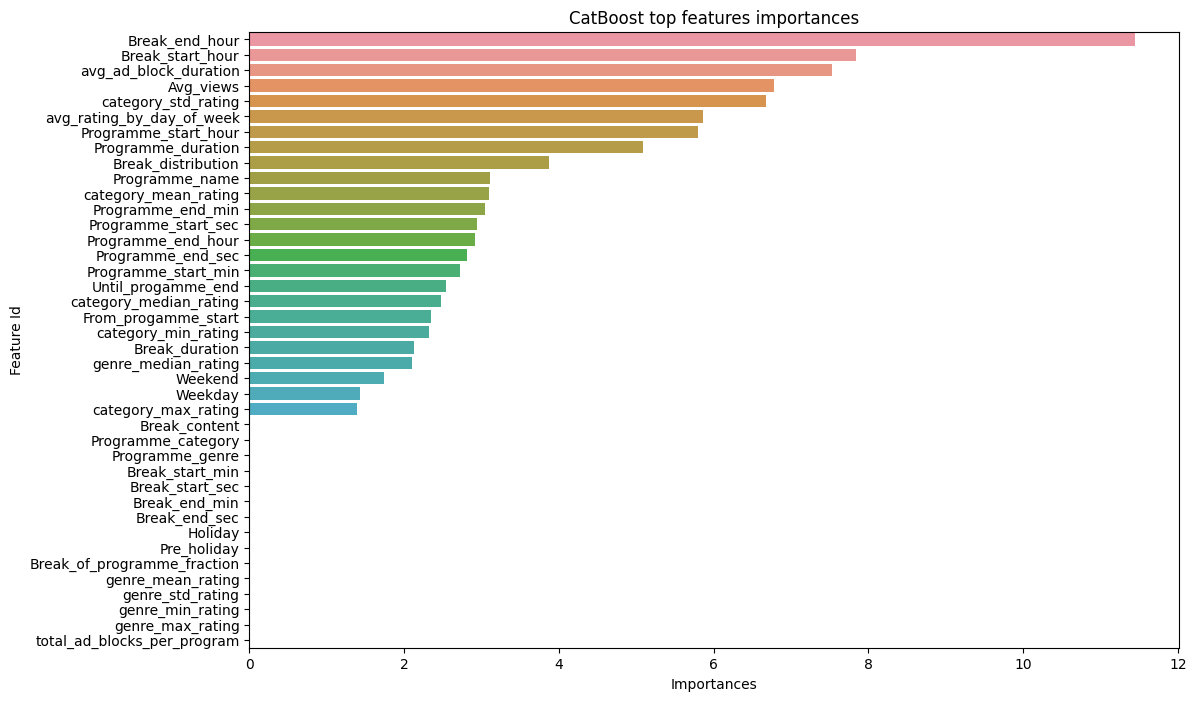

In [137]:
feature_importances = ctb_model.get_feature_importance(prettified=True)
plt.figure(figsize=(12, 8))
sns.barplot(x="Importances", y="Feature Id", data=feature_importances.loc[:, :])
plt.title('CatBoost top features importances after elimination')

## Optuna

In [163]:
def objective(trial):
    scale_target = trial.suggest_float('scale_target', 0.1, 20, log=True)
    params = {
        'depth': trial.suggest_int('depth', 4, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1),
        'colsample_bylevel' : trial.suggest_float("colsample_bylevel", 0.6, 1),
        'random_strength': trial.suggest_float("random_strength", 0.5, 3),          # default=1
             
        'iterations': 8000,
        'loss_function': 'MAPE',
        'eval_metric': 'MAPE',
        'bootstrap_type': 'Bernoulli',
        'l2_leaf_reg': 3.0,            # default
        'allow_writing_files': False,
        'verbose': False,
        'random_seed': 42,
        # 'metric_period': 100,
        # 'od_type': 'Iter',
        # 'od_wait': 200,
        # 'task_type': 'GPU',
        # 'devices': '0:1',
    }
    model = CatBoostRegressor(**params)
    
    y_train_scaled = y_train * scale_target
    y_valid_scaled = y_valid * scale_target
    train_pool = Pool(X_train, label=y_train_scaled , cat_features=cat_features)
    valid_pool = Pool(X_valid, label=y_valid_scaled, cat_features=cat_features)
    
    model.fit(train_pool, 
              eval_set=valid_pool,
              early_stopping_rounds=100,
             )
    metric = MAPE(y_valid_scaled, model.predict(X_valid))
    return metric

In [164]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-12-23 14:12:41,353] A new study created in memory with name: no-name-e27bbf9f-063c-401c-83bd-98979ffdec64
[I 2023-12-23 14:13:25,682] Trial 0 finished with value: 0.19293610644383424 and parameters: {'scale_target': 1.391156580762624, 'depth': 4, 'learning_rate': 0.4722180125245203, 'subsample': 0.6616833695831335, 'colsample_bylevel': 0.6017112380875044, 'random_strength': 2.434128033397312}. Best is trial 0 with value: 0.19293610644383424.
[I 2023-12-23 14:16:38,049] Trial 1 finished with value: 0.16575001824328323 and parameters: {'scale_target': 0.8253279795872187, 'depth': 10, 'learning_rate': 0.07862368507013695, 'subsample': 0.8704115016442413, 'colsample_bylevel': 0.648348308004764, 'random_strength': 1.7332743044387209}. Best is trial 1 with value: 0.16575001824328323.
[I 2023-12-23 14:17:59,103] Trial 2 finished with value: 0.19962501074222744 and parameters: {'scale_target': 6.741738048811855, 'depth': 13, 'learning_rate': 0.17290434180620542, 'subsample': 0.85421426

KeyboardInterrupt: 

## Train on the whole train data

In [210]:
scale_target = 1
full_train_pool = Pool(X, label=y * scale_target, cat_features=cat_features)

ctb_params = dict(iterations=5000,
                   learning_rate=0.0278,
                   depth=9,
                   l2_leaf_reg=3,
                   bootstrap_type='Bernoulli',
                   subsample=0.997,
                   colsample_bylevel=0.795,
                   loss_function='MAPE',
                   eval_metric='MAPE',
                   metric_period=100,
#                    random_strength=3, # more bagging to reduce overfitting
#                    task_type='GPU',
#                    devices='0:1',
                   random_state=42,
                   allow_writing_files=False,
                  )

model = CatBoostRegressor(**ctb_params)
model.fit(full_train_pool)

0:	learn: 0.3327344	total: 49ms	remaining: 4m 5s
100:	learn: 0.1437219	total: 3.88s	remaining: 3m 8s
200:	learn: 0.1293516	total: 7.75s	remaining: 3m 4s
300:	learn: 0.1202778	total: 11.5s	remaining: 2m 58s
400:	learn: 0.1138829	total: 15.3s	remaining: 2m 55s
500:	learn: 0.1084099	total: 19.7s	remaining: 2m 56s
600:	learn: 0.1038126	total: 23.6s	remaining: 2m 53s
700:	learn: 0.1001316	total: 27.6s	remaining: 2m 49s
800:	learn: 0.0972755	total: 31.6s	remaining: 2m 45s
900:	learn: 0.0953829	total: 35.4s	remaining: 2m 41s
1000:	learn: 0.0936075	total: 39.4s	remaining: 2m 37s
1100:	learn: 0.0917885	total: 43.2s	remaining: 2m 32s
1200:	learn: 0.0903457	total: 47.1s	remaining: 2m 28s
1300:	learn: 0.0890319	total: 51.3s	remaining: 2m 25s
1400:	learn: 0.0878229	total: 55.1s	remaining: 2m 21s
1500:	learn: 0.0865388	total: 58.9s	remaining: 2m 17s
1600:	learn: 0.0852788	total: 1m 2s	remaining: 2m 13s
1700:	learn: 0.0843090	total: 1m 6s	remaining: 2m 9s
1800:	learn: 0.0835975	total: 1m 10s	remainin

## Test data read and prediction

In [58]:
test = pd.read_csv('/kaggle/input/xmas2023-case3/test.csv', delimiter=';')

test = test.set_axis(['Date', 'Break_id', 'Break_start', 'Break_end', 'Break_content', 'Break_distribution',
                      'Programme_name', 'Programme_start', 'Programme_end', 'Programme_category', 'Programme_genre', 'Target'], axis=1)
test = test.convert_dtypes()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3329 entries, 0 to 3328
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Date                3329 non-null   string
 1   Break_id            3329 non-null   Int64 
 2   Break_start         3329 non-null   string
 3   Break_end           3329 non-null   string
 4   Break_content       3329 non-null   string
 5   Break_distribution  3329 non-null   string
 6   Programme_name      3329 non-null   string
 7   Programme_start     3329 non-null   string
 8   Programme_end       3329 non-null   string
 9   Programme_category  3329 non-null   string
 10  Programme_genre     3329 non-null   string
 11  Target              0 non-null      Int64 
dtypes: Int64(2), string(10)
memory usage: 318.7 KB


In [59]:
X_test = time_preproc(test, is_test=True)
X_test = gen_base_features(X_test)
X_test = gen_more_features(X_test)
X_test = drop_features(X_test)
X_test = X_test.drop(['Target', 'Date', 'Break_id'], axis=1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3329 entries, 0 to 3328
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Break_content                3329 non-null   string 
 1   Break_distribution           3329 non-null   string 
 2   Programme_name               3329 non-null   string 
 3   Programme_category           3329 non-null   string 
 4   Programme_genre              3329 non-null   string 
 5   Break_start_hour             3329 non-null   int64  
 6   Break_start_min              3329 non-null   int64  
 7   Break_start_sec              3329 non-null   int64  
 8   Break_start_abs              3329 non-null   int64  
 9   Break_end_hour               3329 non-null   int64  
 10  Break_end_min                3329 non-null   int64  
 11  Break_end_sec                3329 non-null   int64  
 12  Break_end_abs                3329 non-null   int64  
 13  Programme_start_ho

In [216]:
# post_proc_1
test_preds = model.predict(X_test)
test_preds = np.array([max(0.01499, pred) for pred in test_preds])
pd.Series(test_preds).to_excel('test_preds.xlsx')